In [1]:
import os
os.chdir('../')

In [2]:
%matplotlib inline
#%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy
from decimal import Decimal
from typing import List, Tuple
from warnings import warn

from cycler import cycler
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import PCA
import scipy.stats as stats
import torch
from torch import nn
import torch.nn.functional as F
import seml
from ogb.nodeproppred import PygNodePropPredDataset
from scipy.stats import sem

import tqdm
tqdm.tqdm.pandas()

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
from notebooks import mpl_latex

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [31]:
mpl_latex.enable_production_mode()

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [7]:
dataset_map = {
    'cora_ml': r'Cora ML',
    'citeseer': r'Citeseer',
    'pubmed': r'PubMed',
    'ogbn-arxiv': r'arXiv',
    'ogbn-products': r'Products',
    'ogbn-papers100M': r'Papers 100M',
}
dataset_order = [dataset_map[k] for k in dataset_map.keys()]

In [8]:
attack_map = {
    'DICE': r'DICE',
    'GANG': r'GANG (ours)',
    'FGSM': r'\greedy FGSM',
    'GreedyRBCD': r'GR-BCD (ours)',
    'PGD': r'PGD',
    'PRBCD': r'PR-BCD (ours)'
}
attack_order = [attack_map[k] for k in attack_map.keys()]

In [9]:
df_global = seml.get_results('kdd21_rgnn_at_scale_attack_evasion_transfer',  # global_attack_benchmark
                             to_data_frame=True,
                             fields=['batch_id', 'slurm', 'config', 'result', 'stats'])
df_global

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/site-packages/seml/evaluation.py:48: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  parsed = pd.io.json.json_normalize(parsed, sep='.')


,_id,batch_id,slurm.experiments_per_job,slurm.sbatch_options.gres,slurm.sbatch_options.mem,slurm.sbatch_options.cpus-per-task,slurm.sbatch_options.time,slurm.sbatch_options.partition,slurm.sbatch_options.nodes,slurm.sbatch_options.job-name,slurm.sbatch_options.array,slurm.sbatch_options.output,slurm.array_id,slurm.task_id,config.overwrite,config.db_collection,config.dataset,config.attack,config.attack_params.loss_type,config.epsilons,config.surrogate_params.n_filters,config.surrogate_params.dropout,config.surrogate_params.train_params.lr,config.surrogate_params.train_params.weight_decay,config.surrogate_params.train_params.patience,config.surrogate_params.train_params.max_epochs,config.binary_attr,config.seed,config.artifact_dir,config.pert_adj_storage_type,config.pert_attr_storage_type,config.model_storage_type,config.device,config.display_steps,config.model_label,result.results,stats.real_time,stats.self.user_time,stats.self.system_time,stats.self.max_memory_bytes,stats.children.user_time,stats.children.system_time,stats.children.max_memory_bytes,stats.pytorch.gpu_max_memory_bytes,config.attack_params.do_synchronize,config.attack_params.keep_heuristic,config.attack_params.search_space_size,config.attack_params.edge_budget,config.attack_params.edge_step_size,config.attack_params.edge_with_random_reverse,config.attack_params.eps,config.attack_params.feature_dedicated_iterations,config.attack_params.stop_optimizing_if_label_flipped,config.attack_params.feature_greedy_opt,config.attack_params.feature_lr,config.surrogate_params.do_checkpoint,config.surrogate_params.n_chunks,config.attack_params.lr_factor,config.attack_params.epsilon,config.make_undirected,config.make_unweighted,config.data_dir,config.data_device
0,1,1,1,gpu:1,16G,4,0-08:00,gpu_large,1,rgnn_at_scale_attack_evasion_transfer_1,0-17,/nfs/homedirs/geisler/code/robust_gnns_at_scal...,6209384,0,1,kdd21_rgnn_at_scale_attack_evasion_transfer,ogbn-arxiv,GreedyRBCD,CE,"[0, 0.01, 0.05, 0.1, 0.25]",64,0.5,0.01,0.001,100,3000,False,0,cache,evasion_transfer_attack_adj,evasion_transfer_attack_attr,pretrained,0,10,None,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",459.620210,1185.129922,24.185182,4159918080,0.018041,0.068767,208396288,1198164480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1,gpu:1,16G,4,0-08:00,gpu_large,1,rgnn_at_scale_attack_evasion_transfer_1,0-17,/nfs/homedirs/geisler/code/robust_gnns_at_scal...,6209384,1,2,kdd21_rgnn_at_scale_attack_evasion_transfer,ogbn-arxiv,GreedyRBCD,MCE,"[0, 0.01, 0.05, 0.1, 0.25]",64,0.5,0.01,0.001,100,3000,False,0,cache,evasion_transfer_attack_adj,evasion_transfer_attack_attr,pretrained,0,10,None,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",561.462416,1603.091859,20.559642,4166885376,0.032583,0.081002,208375808,1203318272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,1,gpu:1,16G,4,0-08:00,gpu_large,1,rgnn_at_scale_attack_evasion_transfer_1,0-17,/nfs/homedirs/geisler/code/robust_gnns_at_scal...,6209384,2,3,kdd21_rgnn_at_scale_attack_evasion_transfer,ogbn-arxiv,GreedyRBCD,CE,"[0, 0.01, 0.05, 0.1, 0.25]",64,0.5,0.01,0.001,100,3000,False,1,cache,evasion_transfer_attack_adj,evasion_transfer_attack_attr,pretrained,0,10,None,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",469.443887,1214.561164,36.859326,4162453504,0.018474,0.071596,204853248,1197155840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,1,gpu:1,16G,4,0-08:00,gpu_large,1,rgnn_at_scale_attack_evasion_transfer_1,0-17,/nfs/homedirs/geisler/code/robust_gnns_at_scal...,6209384,3,4,kdd21_rgnn_at_scale_attack_evasion_transfer,ogbn-arxiv,GreedyRBCD,MCE,"[0, 0.01, 0.05, 0.1, 0.25]",64,0.5,0.01,0.001,100,3000,False,1,cache,evasion_transfer_attack_adj,evasion_transfer_attack_attr,pretrained,0,10,None,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",565.695328,1611.802849,31.253563,4164829184,0.014022,0.097064,204333056,1202429952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [10]:
df_global.columns

Index(['_id', 'batch_id', 'slurm.experiments_per_job',
       'slurm.sbatch_options.gres', 'slurm.sbatch_options.mem',
       'slurm.sbatch_options.cpus-per-task', 'slurm.sbatch_options.time',
       'slurm.sbatch_options.partition', 'slurm.sbatch_options.nodes',
       'slurm.sbatch_options.job-name', 'slurm.sbatch_options.array',
       'slurm.sbatch_options.output', 'slurm.array_id', 'slurm.task_id',
       'config.overwrite', 'config.db_collection', 'config.dataset',
       'config.attack', 'config.attack_params.loss_type', 'config.epsilons',
       'config.surrogate_params.n_filters', 'config.surrogate_params.dropout',
       'config.surrogate_params.train_params.lr',
       'config.surrogate_params.train_params.weight_decay',
       'config.surrogate_params.train_params.patience',
       'config.surrogate_params.train_params.max_epochs', 'config.binary_attr',
       'config.seed', 'config.artifact_dir', 'config.pert_adj_storage_type',
       'config.pert_attr_storage_type', 'conf

# Datasets

In [11]:
dataset_col = 'Dataset'
nodes_col = r'\#Nodes $n$'
edges_col = r'\#Edges $e$'
memory_col = r'Memory'

df_dataset = None

In [12]:
df_dataset = pd.DataFrame({'Dataset': {0: 'Cora ML',
  1: 'Citeseer',
  2: 'PubMed',
  3: 'arXiv',
  4: 'Products',
  5: 'Papers 100M'},
 '\\#Nodes $n$': {0: 2810,
  1: 2110,
  2: 19717,
  3: 169343,
  4: 2449029,
  5: 111059956},
 '\\#Edges $e$': {0: 15962,
  1: 7336,
  2: 88648,
  3: 1166243,
  4: 123718280,
  5: 1615685872}})
df_dataset

,Dataset,\#Nodes $n$,\#Edges $e$
0,Cora ML,2810,15962
1,Citeseer,2110,7336
2,PubMed,19717,88648
3,arXiv,169343,1166243
4,Products,2449029,123718280
5,Papers 100M,111059956,1615685872


In [13]:
if df_dataset is None:
    from ogb.nodeproppred import PygNodePropPredDataset

    from rgnn_at_scale.data import load_dataset

    dataset_df = []
    for dataset in tqdm.tqdm(['cora_ml', 'citeseer', 'pubmed', 'ogbn-arxiv', 'ogbn-products', 'ogbn-papers100M']):
        if dataset.startswith('ogbn'):
            pyg_dataset = PygNodePropPredDataset(root='/nfs/staff-ssd/geisler/dontrobme/datasets', name=dataset)
            nnodes = pyg_dataset[0].x.shape[0]
            nedges = pyg_dataset[0].edge_index.shape[1]
            nfeatures = pyg_dataset[0].x.shape[1]
        else:
            graph = load_dataset(dataset, '/nfs/staff-ssd/geisler/dontrobme/datasets').standardize(
                make_unweighted=True,
                make_undirected=True,
                no_self_loops=True,
                select_lcc=True
            )
            #graph = load_and_standardize(dataset)
            nnodes = graph.adj_matrix.shape[0]
            nedges = graph.adj_matrix.nnz
            nfeatures = graph.attr_matrix.shape[1]
        dataset_df.append({
                dataset_col: dataset_map[dataset].replace(r'rotatebox{90}', r'textbf'),
                nodes_col: nnodes,
                edges_col: nedges,
            })
    df_dataset = pd.DataFrame(dataset_df)
    df_dataset

# PGD

In [14]:
df_pgd = df_global[(df_global['config.attack'] == 'PGD')].copy()

df_pgd[dataset_col] = df_pgd['config.dataset'].apply(lambda dataset: dataset_map[dataset])

df_pgd = df_pgd.groupby(dataset_col)['stats.pytorch.gpu_max_memory_bytes'].max()\
    .sort_values()\
    .rename(memory_col)\
    .reset_index()
df_pgd

,Dataset,Memory
0,Citeseer,1029285376
1,Cora ML,1665038848
2,PubMed,20286210048


In [15]:
df_pgd = pd.merge(df_pgd, df_dataset, on=dataset_col)
df_pgd

,Dataset,Memory,\#Nodes $n$,\#Edges $e$
0,Citeseer,1029285376,2110,7336
1,Cora ML,1665038848,2810,15962
2,PubMed,20286210048,19717,88648


# PR-BCD

In [16]:
df_prbcd = df_global[
    (df_global['config.attack'] == 'PRBCD') 
    & (
        (df_global['config.dataset'] != 'pubmed')
        | (df_global['stats.pytorch.gpu_max_memory_bytes'] < 10e9)
    )
].copy()

df_prbcd[dataset_col] = df_prbcd['config.dataset'].apply(lambda dataset: dataset_map[dataset])

df_prbcd = df_prbcd.groupby(dataset_col)['stats.pytorch.gpu_max_memory_bytes'].max()\
    .sort_values()\
    .rename(memory_col)\
    .reset_index()
df_prbcd

,Dataset,Memory
0,Citeseer,927392256
1,Cora ML,1272866816
2,PubMed,6384252928
3,arXiv,8698990592
4,Products,27621027840


In [17]:
df_prbcd = pd.merge(df_prbcd, df_dataset, on=dataset_col)
df_prbcd

,Dataset,Memory,\#Nodes $n$,\#Edges $e$
0,Citeseer,927392256,2110,7336
1,Cora ML,1272866816,2810,15962
2,PubMed,6384252928,19717,88648
3,arXiv,8698990592,169343,1166243
4,Products,27621027840,2449029,123718280


# Plot

In [18]:
p = np.poly1d(np.polyfit(df_pgd[edges_col], df_pgd[memory_col], 2))

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


<AxesSubplot:xlabel='\\#Edges $e$', ylabel='Memory'>

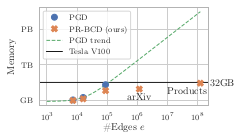

In [38]:
fig, ax = mpl_latex.newfig(width=0.55, ratio_yx=0.6)

plt.plot(df_pgd[edges_col], df_pgd[memory_col], 'o', label=attack_map['PGD'], zorder=3)

plt.plot(df_prbcd[edges_col], df_prbcd[memory_col], 'X', label=attack_map['PRBCD'], zorder=3)

xp = np.logspace(3, np.log10(123_718_280), 500)
plt.plot(xp, p(xp), '--', label=f'{attack_map["PGD"]} trend', zorder=2)

plt.axhline(32e9, label='Tesla V100', color='k', zorder=1)
plt.text(2.5e8, 31e9, '32GB', horizontalalignment='left', verticalalignment='center')
#plt.text(200718280, 7e9, 'Products', horizontalalignment='right', verticalalignment='center')
#plt.text(1166243, 2e9, 'arXiv', horizontalalignment='center', verticalalignment='center')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(edges_col)
plt.ylabel(memory_col)

plt.yticks([1e9, 1e12, 1e15], ['GB', 'TB', 'PB'])

plt.legend()

mpl_latex.savefig(f'latex/assets/memory_comparison_pgd_prbcd', fig, close_fig=False)

plt.gca()